### Imports 

In [14]:
%matplotlib inline
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import itertools

### Load & Prep Data

In [2]:
train_path  = './DATA/train'
validation_path  = './DATA/validation'
test_path  = './DATA/test'

<p>ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches).<br>
    <b>Note:</b> In this example, we won't be doing any image augmentation.</p>

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224, 224), 
                                                         batch_size=10)

Found 1362 images belonging to 10 classes.


In [4]:
validation_batches = ImageDataGenerator().flow_from_directory(validation_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

Found 600 images belonging to 10 classes.


In [5]:
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 100 images belonging to 10 classes.


### Load Base Model
#### VGG16 CNN Model pre-trained on ImageNet dataset

In [6]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Freeze the Classification Layers in Base Model

In [7]:
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Define New Model

In [8]:
# get last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Compile the New Model

In [9]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the New Model

In [10]:
checkpointer = ModelCheckpoint(filepath='sign-language.model.hdf5', save_best_only=True)

In [11]:
history = new_model.fit(train_batches, 
                        steps_per_epoch=18, 
                        validation_data=validation_batches, 
                        validation_steps=3, 
                        epochs=20, 
                        verbose=1, 
                        callbacks=[checkpointer])

Epoch 1/20
18/18 [==============================] - 46s 3s/step - loss: 3.2129 - accuracy: 0.2722 - val_loss: 2.1203 - val_accuracy: 0.1889
Epoch 2/20
18/18 [==============================] - 47s 3s/step - loss: 1.6083 - accuracy: 0.4500 - val_loss: 1.0063 - val_accuracy: 0.6444
Epoch 3/20
18/18 [==============================] - 46s 3s/step - loss: 0.7572 - accuracy: 0.7833 - val_loss: 0.8415 - val_accuracy: 0.6667
Epoch 4/20
18/18 [==============================] - 46s 3s/step - loss: 0.4175 - accuracy: 0.8944 - val_loss: 0.6573 - val_accuracy: 0.8444
Epoch 5/20
18/18 [==============================] - 45s 2s/step - loss: 0.2583 - accuracy: 0.9128 - val_loss: 0.3736 - val_accuracy: 0.8889
Epoch 6/20
18/18 [==============================] - 47s 3s/step - loss: 0.1888 - accuracy: 0.9444 - val_loss: 0.2151 - val_accuracy: 0.9556
Epoch 7/20
18/18 [==============================] - 44s 2s/step - loss: 0.1027 - accuracy: 0.9709 - val_loss: 0.3593 - val_accuracy: 0.9333
Epoch 8/20
18/18 [==

### Visualize Training

In [12]:
def plot_training_history(history):          
    hist = pd.DataFrame(history.history)          
    hist['epoch'] = history.epoch          
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Accuracy')          
    plt.plot(hist['epoch'], hist['accuracy'] * 100, label='Train Accuracy')          
    plt.plot(hist['epoch'], hist['val_accuracy'] * 100, label='Validation Accuracy')
    plt.ylim([0, 100])          
    plt.legend()  
    
    plt.figure()          
    plt.xlabel('Epoch')          
    plt.ylabel('Loss')          
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')          
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.ylim([0,2])
    plt.legend()          
    plt.show()

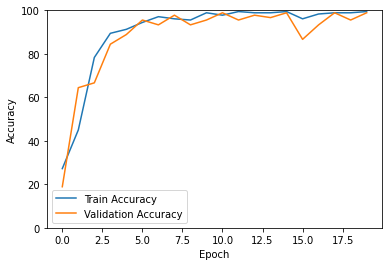

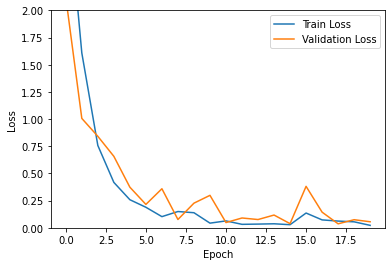

In [15]:
plot_training_history(history)

### Evaluate Model